In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(glue))
suppressMessages(library(data.table))

In [2]:
suppressMessages(library(cowplot))
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 180)
theme_set(theme_cowplot())

In [3]:
setwd("~/cdai3/SpliFi/analysis")

In [4]:
library(patchwork)
library(magrittr)


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘magrittr’




The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [5]:
suppressMessages(library(furrr))
plan(multisession, workers = 6)

In [6]:
# support functions

computeUnprodRatio <- function(tissue_rds) {

    introns <- readRDS(tissue_rds)
    datacols <- names(introns)[5:ncol(introns)]
    # remove clu_type == N, clusters with only unproductive introns
    introns  <- introns[str_detect(clu_type, 'PR')]
    # total reads (by sample)
    totals <- colSums(introns[, ..datacols])
    # unproudctive reads (by sample)
    unprod <- introns[intron_type == 'UP', ..datacols] %>% colSums
    # unproductive reads / total reads
    if (all(names(totals) == names(unprod))) {
        unprod_ratio <- round(unprod / totals, 5)
    } else {
        stop('samples of totals and unprod are not the same')
    }

    return(unprod_ratio)

}


# Load input

1. numerators from leafcutter output with constitutive introns
2. junction classifier, a by product of leafcutter
3. gene code annotation (mainly gene length)
4. APPRIS1 introns

In [66]:
cts = readRDS('../data/ExtractFractions/Geuvadis/EUR.numerators_constcounts.noise_by_intron.rds')


In [67]:
cts[1:5, 1:8]

chrom,clu,clu_type,intron_type,HG00096,HG00097,HG00099,HG00100
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
chr1:779092:803918:clu_1_+:IN,clu_1,IN,IN,0,1,2,1
chr1:804222:804775:clu_2_+:IN,clu_2,IN,IN,0,0,0,2
chr1:804222:807216:clu_2_+:IN,clu_2,IN,IN,0,3,0,0
chr1:807323:809657:clu_3_+:IN,clu_3,IN,IN,0,0,0,0
chr1:827775:829002:clu_4_+:IN,clu_4,IN,IN,12,25,8,15


Junction classifer output from leafcutter2 run

In [68]:
juncClass <- fread('../code/results/pheno/noisy/Geuvadis/EUR/wConst_junction_classifications.txt')

In [70]:
# make intron coordinates same format as in leafcutter
juncClass[, Intron_coord := str_replace(Intron_coord, '\\-', ':')]

In [71]:
juncClass[1:3,] %>% print
dim(juncClass)

   Gene_name       Intron_coord Annot Coding   UTR
1:    KLHL17 chr1:964530:964962  TRUE   TRUE FALSE
2:    KLHL17 chr1:964530:964934 FALSE  FALSE FALSE
3:    KLHL17 chr1:964180:964348  TRUE   TRUE FALSE


[1] 569118      5

In [72]:
gtf <- fread('../../annotations/hg38/gencode.v43.primary_assembly.annotation.csv.gz') %>% 
    .[feature == 'gene', .(seqname, start, end, strand, feature, gene_name, gene_type)]

In [73]:
gtf[, gene_len := end - start]

In [74]:
gtf[1:2]

seqname,start,end,strand,feature,gene_name,gene_type,gene_len
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
chr1,11869,14409,+,gene,DDX11L2,lncRNA,2540
chr1,12010,13670,+,gene,DDX11L1,transcribed_unprocessed_pseudogene,1660


Appris_principal_1 introns

In [75]:
app1_introns <- fread('../code/resources/gencode.v43.primary.appris1-introns.bed')

In [76]:
app1_introns <- setNames(app1_introns, c("seqname", "start", "end", "name", "indx", "strand"))

In [77]:
app1_introns[, Intron_coord := paste(seqname, start, end, sep=":")]

In [78]:
dim(app1_introns)
app1_introns %>% head

[1] 190872      7

seqname,start,end,name,indx,strand,Intron_coord
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>
chr1,65433,65519,intron|OR4F5|ENST00000641515.2,1,+,chr1:65433:65519
chr1,65573,69036,intron|OR4F5|ENST00000641515.2,2,+,chr1:65573:69036
chr1,944800,945056,intron|NOC2L|ENST00000327044.7,18,-,chr1:944800:945056
chr1,945146,945517,intron|NOC2L|ENST00000327044.7,17,-,chr1:945146:945517
chr1,945653,946172,intron|NOC2L|ENST00000327044.7,16,-,chr1:945653:946172
chr1,946286,946401,intron|NOC2L|ENST00000327044.7,15,-,chr1:946286:946401


# Annotate introns

Get the non-data columns separately from cts

In [80]:
datcols <- names(cts)[5:ncol(cts)]
idcols <- names(cts)[1:4]

In [82]:
# easier to make it into a data.table
introns <- cts[, ..idcols]
introns[, Intron_coord := str_split(chrom, ":") %>% 
  map_chr(~paste(.x[1], .x[2], .x[3], sep=":", collapse = ""))]
introns[1:5]
dim(introns)

chrom,clu,clu_type,intron_type,Intron_coord
<chr>,<chr>,<chr>,<chr>,<chr>
chr1:779092:803918:clu_1_+:IN,clu_1,IN,IN,chr1:779092:803918
chr1:804222:804775:clu_2_+:IN,clu_2,IN,IN,chr1:804222:804775
chr1:804222:807216:clu_2_+:IN,clu_2,IN,IN,chr1:804222:807216
chr1:807323:809657:clu_3_+:IN,clu_3,IN,IN,chr1:807323:809657
chr1:827775:829002:clu_4_+:IN,clu_4,IN,IN,chr1:827775:829002


[1] 228671      5

bring in gene_name info from the classifer file

In [83]:
introns <- left_join(introns, juncClass[, .(Intron_coord, Gene_name)], by = 'Intron_coord')

This left_join causes duplication because in the classifier, some junctions are associated with multiple genes. So we need to just pick 1 gene.

In [84]:
introns[, rid := rowid(Intron_coord)]
introns <- introns[rid == 1]
introns[, rid := NULL]

Warning message in `[.data.table`(introns, , `:=`(rid, rowid(Intron_coord))):
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


now we should only have 1 gene per junction

In [85]:
introns[1:5]

chrom,clu,clu_type,intron_type,Intron_coord,Gene_name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1:779092:803918:clu_1_+:IN,clu_1,IN,IN,chr1:779092:803918,NA
chr1:804222:804775:clu_2_+:IN,clu_2,IN,IN,chr1:804222:804775,NA
chr1:804222:807216:clu_2_+:IN,clu_2,IN,IN,chr1:804222:807216,NA
chr1:807323:809657:clu_3_+:IN,clu_3,IN,IN,chr1:807323:809657,NA
chr1:827775:829002:clu_4_+:IN,clu_4,IN,IN,chr1:827775:829002,NA


In [86]:
dim(introns[intron_type == 'PR'])

[1] 161043      6

59% of all protein coding introns are annotated as appris_principle_1 introns

In [87]:
length(intersect(introns$Intron_coord, app1_introns$Intron_coord)) / length(introns[intron_type == "PR", Intron_coord])

[1] 0.590302

::: {.callout-note}
### Todos

Actually, only look at clusters that have `appris_principal_1` tag. Each cluster should only have 1 transcript with that dag.
:::

In [88]:
dim(introns)
uniqueN(introns$Intron_coord)

[1] 228671      6

[1] 228671

In [89]:
introns[1:5]

chrom,clu,clu_type,intron_type,Intron_coord,Gene_name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1:779092:803918:clu_1_+:IN,clu_1,IN,IN,chr1:779092:803918,NA
chr1:804222:804775:clu_2_+:IN,clu_2,IN,IN,chr1:804222:804775,NA
chr1:804222:807216:clu_2_+:IN,clu_2,IN,IN,chr1:804222:807216,NA
chr1:807323:809657:clu_3_+:IN,clu_3,IN,IN,chr1:807323:809657,NA
chr1:827775:829002:clu_4_+:IN,clu_4,IN,IN,chr1:827775:829002,NA


# Cluster level analysis

In [90]:
dim(cts)
dim(introns)
all(cts$chrom == introns$chrom)
cts[1:5,1:7]

[1] 228671    377

[1] 228671      6

[1] TRUE

chrom,clu,clu_type,intron_type,HG00096,HG00097,HG00099
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>
chr1:779092:803918:clu_1_+:IN,clu_1,IN,IN,0,1,2
chr1:804222:804775:clu_2_+:IN,clu_2,IN,IN,0,0,0
chr1:804222:807216:clu_2_+:IN,clu_2,IN,IN,0,3,0
chr1:807323:809657:clu_3_+:IN,clu_3,IN,IN,0,0,0
chr1:827775:829002:clu_4_+:IN,clu_4,IN,IN,12,25,8


## Correlation between percent of unproductive junction reads in LeafCutter clusters versus length of the most used productive intron in the cluster

First subset to clusters that have at least 1 PR intron, and compute mean read counts for each intron

In [40]:
dt  <- cts[str_detect(clu_type, 'PR')
    ][, .(chrom, clu, clu_type, intron_type, meanReads = rowMeans(.SD)), .SDcols = datcols]

Find the most used PR intron for each cluster. 

In [91]:
dt <- dt[, .(chrom, meanReads, rk = frank(-meanReads, ties.method = 'first')), by = .(clu, clu_type, intron_type)
    ][, .(clu, clu_type, intron_type, chrom, meanReads, rk = if_else(intron_type != 'PR', NA, rk))]

Add intron length

In [92]:
dt$intron_length <- str_split(dt$chrom, ':', simplify = F)  %>% 
    map_int(\(x) as.integer(x[[3]]) - as.integer(x[[2]]))

get back sample level read counts

In [94]:
dt  <- left_join(dt, cts[, c('chrom', datcols), with = F], by = 'chrom')

In [95]:
dt[1:5]
dim(dt)

clu,clu_type,intron_type,chrom,meanReads,rk,intron_length,HG00096,HG00097,HG00099,⋯,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
clu_8,"PR,UP",PR,chr1:960800:961292:clu_8_+:PR,0.1742627,1,492,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
clu_8,"PR,UP",UP,chr1:960800:961628:clu_8_+:UP,0.1983914,NA,828,0,0,0,⋯,0,2,0,0,0,0,0,0,0,0
clu_9,PR,PR,chr1:961750:961825:clu_9_+:PR,7.4932976,1,75,11,11,4,⋯,4,1,5,5,8,5,7,8,9,13
clu_10,"PR,UP",UP,chr1:962047:962285:clu_10_+:UP,1.2654155,NA,238,0,1,1,⋯,2,0,2,0,2,1,3,1,1,0
clu_10,"PR,UP",PR,chr1:962047:962354:clu_10_+:PR,4.2278820,1,307,4,1,6,⋯,8,1,9,20,3,2,1,3,3,3


[1] 198966    380

In [96]:
# cluster level total
total_by_clu  <- dt[, lapply(.SD, sum), .SDcols = datcols, by = clu]

In [97]:
# cluster level unproductive
unprod_by_clu  <- dt[intron_type == 'UP', lapply(.SD, sum), .SDcols = datcols, by = clu]

In [40]:
# unprod_ratio_by_clu <- map_dfr(total_by_clu$clu,
#     \(x) {
#         if (x %in% unprod_by_clu$clu) {
#             dt <- unprod_by_clu[clu == x, ..datcols] / (total_by_clu[clu == x, ..datcols] + 1e-5)
#         } else {
#             dt <- 0 / (total_by_clu[clu == x, ..datcols] + 1e-5)
#         }
#         dt <- cbind(clu = x, round(dt, 5))
#     }
# )

In [41]:
# saveRDS(list("unprod_ratio_by_clu" = unprod_ratio_by_clu),
#         '2024-01-20-Geuvadis.EUR.unprod_ratio_by_clu.rds')

In [98]:
unprod_ratio_by_clu = readRDS('2024-01-20-Geuvadis.EUR.unprod_ratio_by_clu.rds')[['unprod_ratio_by_clu']]

In [100]:
unprod_by_clu[1:2]
total_by_clu[1:5]
unprod_ratio_by_clu[1:5]

clu,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00105,⋯,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
clu_8,0,0,0,0,0,0,0,0,0,⋯,0,2,0,0,0,0,0,0,0,0
clu_10,0,1,1,1,0,2,0,1,0,⋯,2,0,2,0,2,1,3,1,1,0


clu,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00105,⋯,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
clu_8,1,0,0,0,0,0,0,0,0,⋯,0,2,0,0,0,0,0,0,0,0
clu_9,11,11,4,7,4,0,7,7,7,⋯,4,1,5,5,8,5,7,8,9,13
clu_10,4,2,7,4,0,2,2,4,3,⋯,10,1,11,20,5,3,4,4,4,3
clu_11,7,7,5,3,8,0,8,5,2,⋯,12,3,11,9,4,2,3,6,5,0
clu_12,12,13,1,1,5,0,8,4,2,⋯,1,3,1,3,0,2,0,1,2,0


clu,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00105,⋯,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
clu_8,0,0.00000,0.00000,0.00,0.0,0,0.000,0.00,0.0,⋯,0.00000,1,0.00000,0.00000,0.0,0.00000,0.00,0.00000,0.00,0
clu_9,0,0.00000,0.00000,0.00,0.0,0,0.000,0.00,0.0,⋯,0.00000,0,0.00000,0.00000,0.0,0.00000,0.00,0.00000,0.00,0
clu_10,0,0.50000,0.14286,0.25,0.0,1,0.000,0.25,0.0,⋯,0.20000,0,0.18182,0.00000,0.4,0.33333,0.75,0.25000,0.25,0
clu_11,0,0.00000,0.00000,0.00,0.0,0,0.000,0.00,0.0,⋯,0.00000,0,0.00000,0.00000,0.0,0.00000,0.00,0.00000,0.00,0
clu_12,0,0.30769,0.99999,0.00,0.2,0,0.875,0.25,0.5,⋯,0.99999,0,0.00000,0.33333,0.0,1.00000,0.00,0.99999,0.50,0


Bring together longest protein coding intron length and percent unproductive reads per cluster

In [101]:
str_detect('IN,NE,PR', '(PR\\,UP)')

[1] FALSE

In [102]:
dt$clu_type %>% unique

[1] "PR,UP"       "PR"          "NE,PR"       "NE,PR,UP"    "IN,PR,UP"   
[6] "IN,NE,PR"    "IN,NE,PR,UP" "IN,PR"

In [104]:
dt[1:3, 1:8]

clu,clu_type,intron_type,chrom,meanReads,rk,intron_length,HG00096
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>
clu_8,"PR,UP",PR,chr1:960800:961292:clu_8_+:PR,0.1742627,1,492,1
clu_8,"PR,UP",UP,chr1:960800:961628:clu_8_+:UP,0.1983914,NA,828,0
clu_9,PR,PR,chr1:961750:961825:clu_9_+:PR,7.4932976,1,75,11


In [105]:
unprod_ratio_by_clu_means <- inner_join(unprod_ratio_by_clu, 
    dt[rk == 1 & str_detect(clu_type, '(PR\\,UP)'), .(clu, clu_type, intron_length)], 
    by = 'clu') %>%
    .[, .(clu, intron_length, clu_type, meanUnprod = rowMeans(.SD)), .SDcols = datcols]


In [106]:
unprod_ratio_by_clu_means[1:5]
unprod_ratio_by_clu_means %>% dim

clu,intron_length,clu_type,meanUnprod
<chr>,<int>,<chr>,<dbl>
clu_8,492,"PR,UP",0.1275365
clu_10,307,"PR,UP",0.2366898
clu_12,191,"PR,UP",0.2889632
clu_14,168,"PR,UP",0.5067805
clu_15,432,"PR,UP",0.0149981


[1] 16841     4

In [107]:
intron_length_breaks = c(0, 1000, 5000, 20000, 50000, Inf)
intron_length_labels = c('<1kb', '1-5kb', '5-20kb', '20-50kb', '>50kb')

In [108]:
unprod_ratio_by_clu_means[, intron_length_bin := cut(intron_length, breaks = intron_length_breaks, labels = intron_length_labels, right = F)]

In [109]:
# these clusters have and only have 1 appris1 intron
app1_clusters <- introns[Intron_coord %in% app1_introns$Intron_coord & intron_type == 'PR'
       ][, .N, by = .(clu)][N == 1, clu]

In [110]:
unprod_ratio_by_clu_means %$% 
    cor.test(meanUnprod, intron_length, method = 'spearman')

Warning message in cor.test.default(meanUnprod, intron_length, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  meanUnprod and intron_length
S = 6.8192e+11, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1433922 


In [111]:
unprod_ratio_by_clu_means[clu %in% app1_clusters] %$% 
    cor.test(meanUnprod, intron_length, method = 'spearman')

Warning message in cor.test.default(meanUnprod, intron_length, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  meanUnprod and intron_length
S = 4.3067e+10, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1749178 


cummulative distribution of percent unproductive reads per cluster

In [112]:
unprod_ratio_by_clu_means[, .N, by = .(meanUnprod == 0)]

meanUnprod,N
<lgl>,<int>
FALSE,16841


In [113]:
unprod_ratio_by_clu_means[1:5]

clu,intron_length,clu_type,meanUnprod,intron_length_bin
<chr>,<int>,<chr>,<dbl>,<fct>
clu_8,492,"PR,UP",0.1275365,<1kb
clu_10,307,"PR,UP",0.2366898,<1kb
clu_12,191,"PR,UP",0.2889632,<1kb
clu_14,168,"PR,UP",0.5067805,<1kb
clu_15,432,"PR,UP",0.0149981,<1kb


In [122]:
unprod_ratio_by_clu_means$meanUnprod %>% summary

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000107 0.0076504 0.0187047 0.0518337 0.0502399 0.9937925 

In [310]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 180)

In [299]:
theme_set(theme_cowplot(font_size = 18))

In [300]:

minPSItoPlot <- 0.005

In [301]:
p1  <- unprod_ratio_by_clu_means %>% 
    ggplot() + stat_ecdf(aes(x = if_else(meanUnprod < 1e-7, 0, meanUnprod), color = intron_length_bin)) +
        scale_color_brewer(type = 'qual', palette = 'Blues') +
        scale_x_log10(breaks = c(0, .01, .1, 1), 
                      labels = c("0%", "1%", "10%", "100%"), 
                      n.breaks = 5, expand = c(.3, 0)) + 
        coord_cartesian(xlim = c(.005, 1)) +
        labs(x = "Unproductive splicing", title = 'Unproductive splicing by intron length', 
             y = "Cumulative distribution", color = "Intron length",
             caption = glue('Spearman rho=0.14 ***, N(clu)={uniqueN(unprod_ratio_by_clu_means$clu)}')) +
        theme(legend.position = 'bottom')

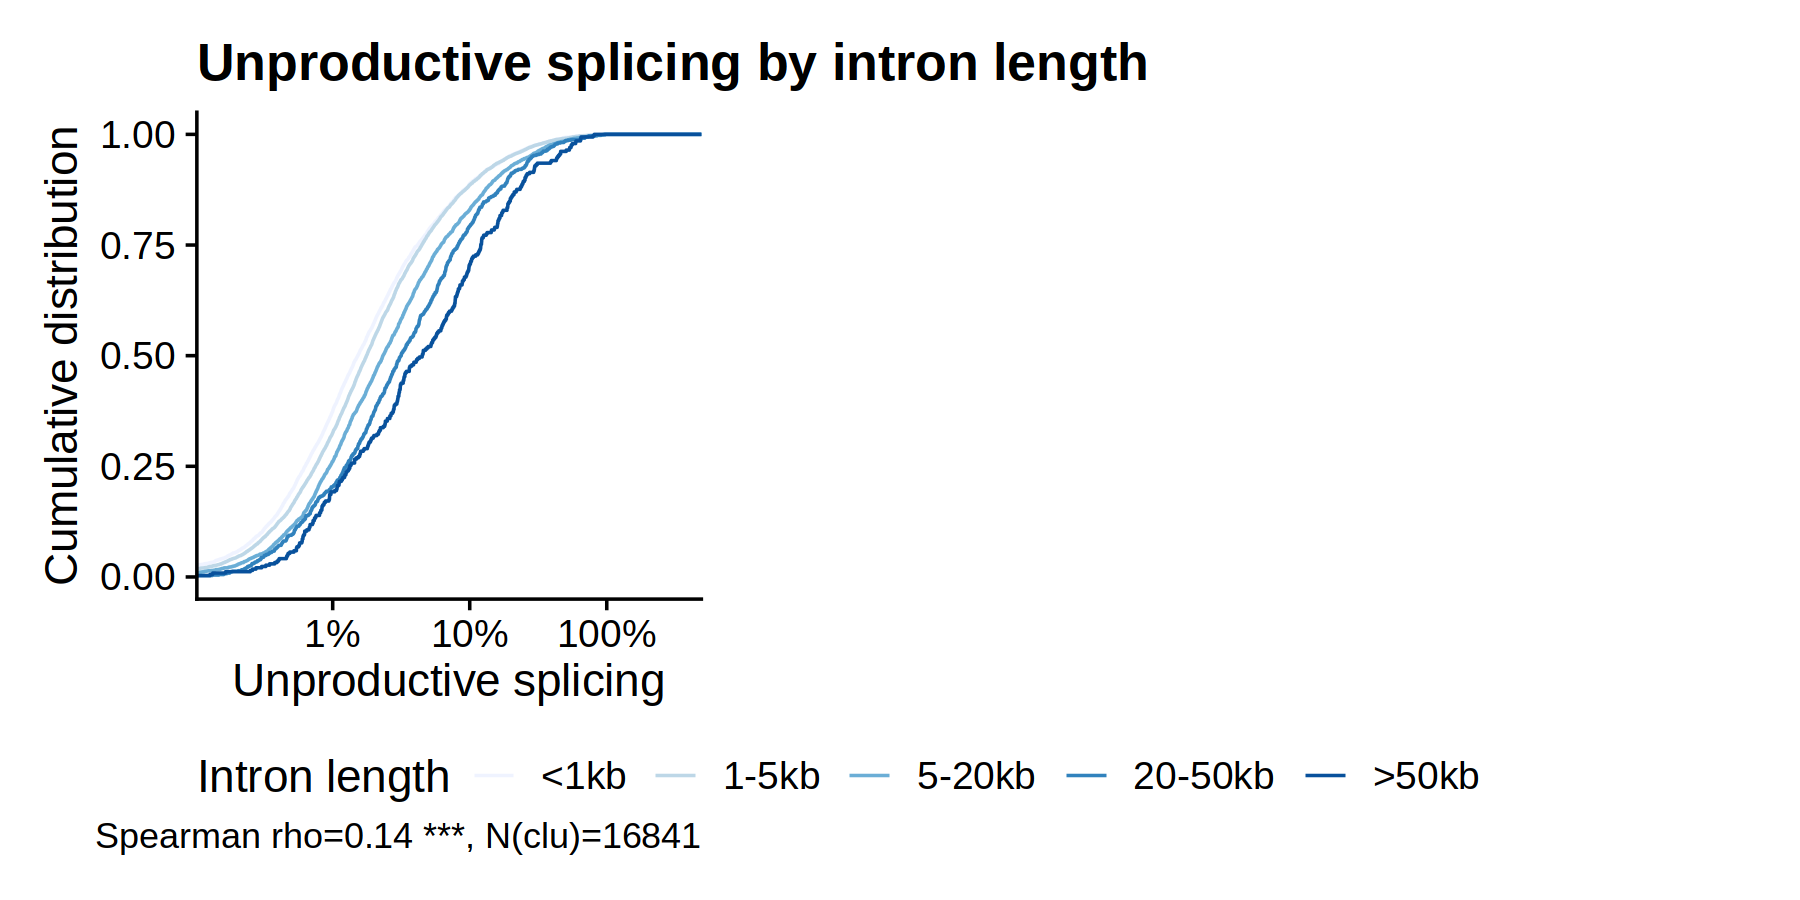

In [313]:
p1 + plot_spacer() + plot_layout(widths = c(2,4))

Next, try a version where clusters have and just have 1 appris1 intron

In [318]:

p2 <- unprod_ratio_by_clu_means[clu %in% app1_clusters] %>% 
    ggplot() + stat_ecdf(aes(x = meanUnprod, color = intron_length_bin)) +
        scale_color_brewer(type = 'qual', palette = 'Blues') +
        scale_x_log10(breaks = c(0, .01, .1, 1), labels = c("0%", "1%", "10%", "100%"), 
                      n.breaks = 5, expand = c(.2, 0)) +
        coord_cartesian(xlim = c(.005, 1)) +
        labs(x = "Unproductive splicing", title = "Clusters with Appris_principle_1 PR and UP introns",
             y = "Cumulative distribution",
             caption = glue('Spearman rho=0.17 ***, N(clu)={uniqueN(unprod_ratio_by_clu_means[clu %in% app1_clusters])}')) + 
        theme(legend.position = 'bottom')

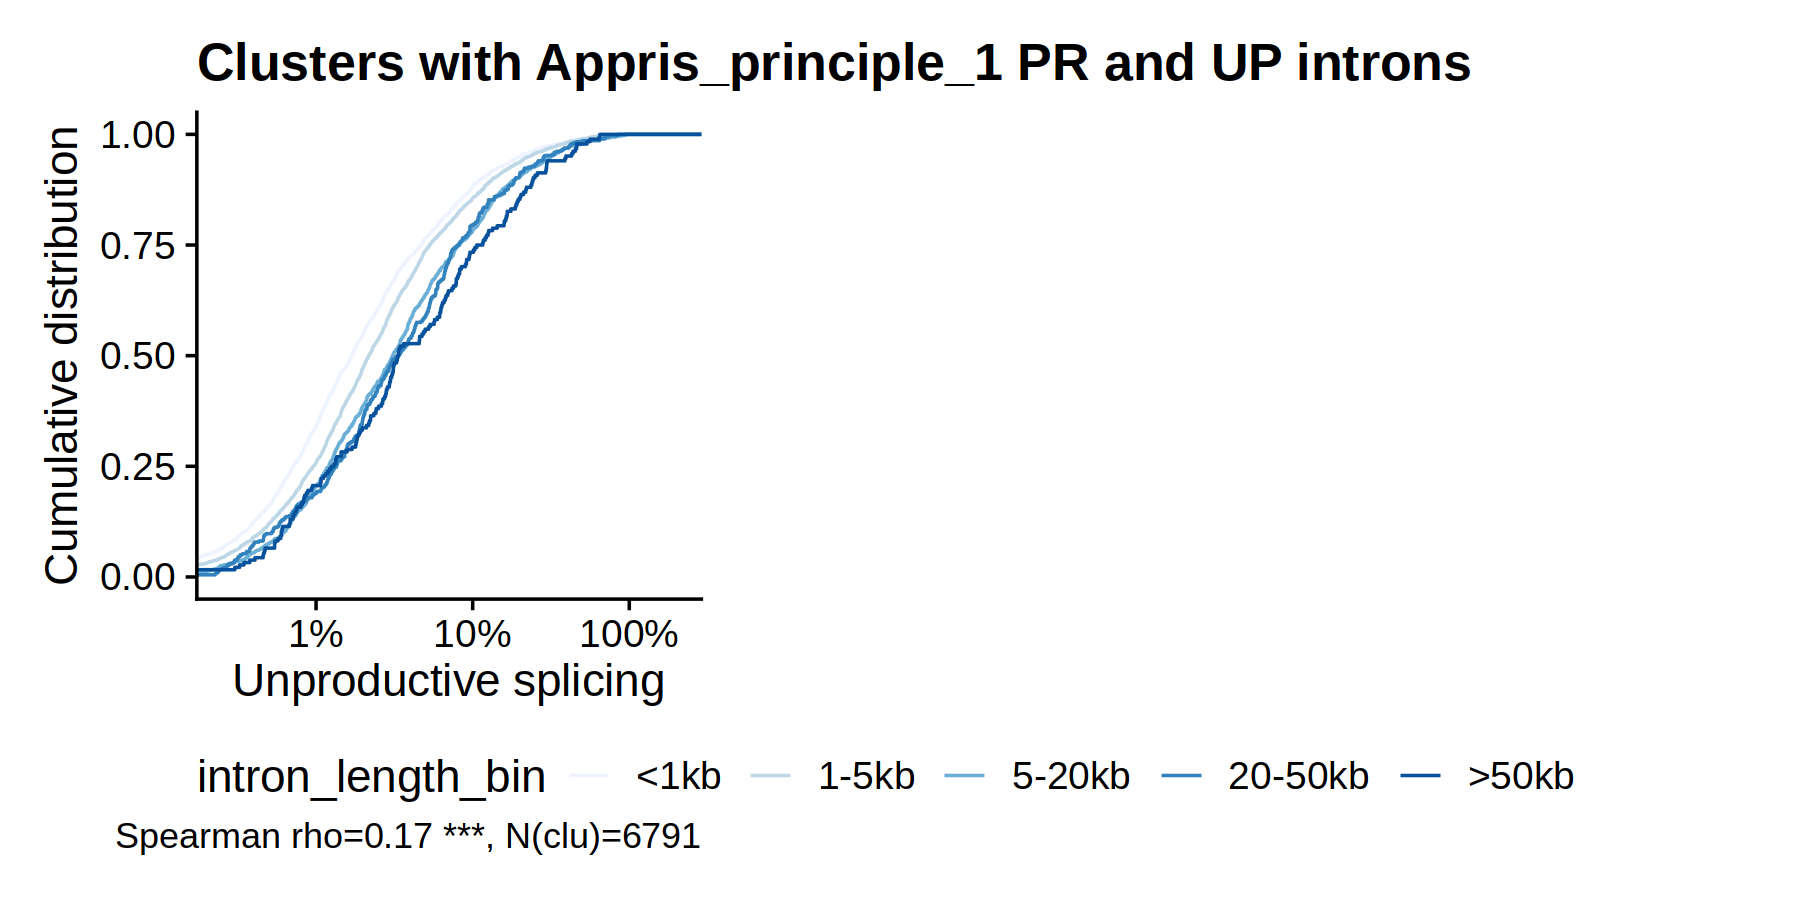

In [319]:
p2 + plot_spacer() + plot_layout(widths = c(1, 2))

## Count the number of reads per gene

Since we have gene_name now, just need to bring back the data columns from cts.

Do not consider intergenic junctions.

In [320]:
counts_by_gene <- left_join(introns, cts[, c('chrom', datcols), with = FALSE], by = c('chrom' = 'chrom')) %>% 
    .[Gene_name != 'NA']

Now, sum up junction read counts per gene.

In [321]:
# sum total reads by gene
total_by_gene <- counts_by_gene[, c("Gene_name", datcols), with = FALSE
    ][, lapply(.SD, sum), by = Gene_name, .SDcols = datcols]

In [322]:
# sum unproductive reads by gene
unprod_by_gene <- counts_by_gene[intron_type == 'UP', c("Gene_name", datcols), with = FALSE
    ][, lapply(.SD, sum), by = Gene_name, .SDcols = datcols]

In [323]:
getRPKM <- function(reads, lengths) {
    reads = as.double(reads)
    lengths = as.double(lengths)
    total = sum(reads)
    rpkm = map2_dbl(reads, lengths, ~ 1e9 * as.double(.x) / (total * .y))
    return(rpkm)
}

In [324]:
gene_lens <- left_join(total_by_gene[, .(Gene_name)], gtf[gene_type == 'protein_coding', .(gene_name, gene_len)], by = c(Gene_name = 'gene_name'))
gene_lens <- gene_lens[, .(gene_len = max(gene_len)), by = 'Gene_name']

In [325]:
dim(total_by_gene)
dim(gene_lens)
all(total_by_gene$Gene_name == gene_lens$gene_lens$Gene_name)

[1] 12987   374

[1] 12987     2

[1] TRUE

In [326]:
gene_lens[1:2]

Gene_name,gene_len
<chr>,<int>
KLHL17,5135
PLEKHN1,9383


In [327]:
# compute rpkm for totals per gene
rpkm_by_gene <- total_by_gene[, lapply(.SD, getRPKM, gene_lens$gene_len), .SDcols = datcols]

In [328]:
rpkm_by_gene  <- cbind(total_by_gene[, .(Gene_name)], rpkm_by_gene)

In [329]:
# unprod_ratio_by_gene <- map_dfr(total_by_gene$Gene_name,
#     \(x) {
#         if (x %in% unprod_by_gene$Gene_name) {
#             dt <- unprod_by_gene[Gene_name == x, ..datcols] / (total_by_gene[Gene_name == x, ..datcols] + 1e-5)
#         } else {
#             dt <- 0 / (total_by_gene[Gene_name == x, ..datcols] + 1e-5)
#         }
#         dt <- cbind(Gene_name = x, round(dt, 5))
#     }
# )

In [330]:
 # #save unprod_ratio_by_gene into RDS since it takes 15 minutes to compute
 # saveRDS(list("unprod_ratio_by_gene" = unprod_ratio_by_gene,
 #              "unprod_ratio_by_clu" = unprod_ratio_by_clu
 #             ),
 #         '2024-01-20-Geuvadis.EUR.storedcomputes.rds')

In [331]:
unprod_ratio_by_gene = readRDS('2024-01-20-Geuvadis.EUR.storedcomputes.rds')[['unprod_ratio_by_gene']]

In [332]:
unprod_ratio_by_gene[1:5,1:5]

Gene_name,HG00096,HG00097,HG00099,HG00100
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
KLHL17,0.10000,0.08696,0.07692,0.06250
PLEKHN1,0.00000,0.00000,0.00000,0.00000
ISG15,0.00000,0.00000,0.00000,0.00000
AGRN,0.00145,0.00432,0.00426,0.00797
SCNN1D,0.00000,0.00000,0.00000,0.00000


In [333]:
unprod_ratio_by_gene[1:5, .SD, .SDcols = datcols] %>% as.matrix %>% matrixStats::rowMedians(.)

[1] 0.09677 0.00000 0.00000 0.00348 0.00000

In [334]:
rpkm_by_gene[1:5]

Gene_name,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00105,⋯,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KLHL17,1.51486928,1.1961618,0.73257131,0.87405173,1.43396562,0.1293469,1.4904921,1.2625530,0.52079842,⋯,1.29898355,1.04723734,1.2053541,1.20372262,0.59080544,0.45238953,0.67036360,1.6506757,1.10868080,0.812482625
PLEKHN1,0.23028804,0.1366162,0.05139892,0.06975778,0.11373349,0.0000000,0.2063809,0.0744103,0.09161211,⋯,0.05712509,0.25471899,0.1168130,0.12099616,0.13070703,0.04683900,0.05706827,0.1307494,0.04396693,0.175789641
ISG15,7.86153205,4.7504985,8.17587917,6.03507736,8.55194237,0.7103528,18.8457943,10.7243526,12.33971008,⋯,18.57516776,11.26474574,6.9226925,10.83839857,5.56769317,6.23533383,3.13928999,26.5216826,10.15193723,3.453304225
AGRN,4.95329225,3.0906045,2.51869296,1.30395226,3.25798753,0.2029602,2.8690075,3.0145830,1.00689801,⋯,1.95553314,3.45245494,2.4555170,2.30227812,0.89117930,1.04646365,1.18362787,2.4289933,3.97895686,1.014781830
SCNN1D,0.09692161,0.1059655,0.04992076,0.08872238,0.07364178,0.0000000,0.1749923,0.1290542,0.04119327,⋯,0.05137245,0.04295028,0.0444916,0.07616808,0.01670369,0.00541571,0.01319692,0.1154447,0.05693667,0.008369321


In [335]:
rpkm_by_gene[1:5][, .(x = rowMeans(.SD)), .SDcols = datcols]

x
<dbl>
1.18244429
0.09041482
6.45361506
2.48734927
0.07772126


In [336]:
meanRPKM_by_gene <- rpkm_by_gene[, .(Gene_name, meanrpkm = rowMeans(.SD)), .SDcols = datcols]

In [337]:
quantile(runif(20, 0, 35), seq(0,1,.1))

0%       10%       20%       30%       40%       50%       60%       70% 
 1.550849  2.836669  6.978851  8.444358 13.458994 15.034467 16.534716 19.849211 
      80%       90%      100% 
25.576204 27.747676 30.737804

In [338]:
quantile(meanRPKM_by_gene$meanrpkm, seq(0, 1, .2), na.rm = T)

0%          20%          40%          60%          80%         100% 
7.659952e-06 2.619383e-02 1.732401e-01 6.560126e-01 2.464601e+00 3.342120e+03

In [339]:
rpkm_breaks <- c(0, 0.02619, 0.1732, 0.656, 2.4646, Inf)
rpkm_labels <- c("Q1 - lowly expressed", "Q2", "Q3", "Q4", "Q5 - highly expressed")

In [340]:
meanRPKM_by_gene <- meanRPKM_by_gene[, .(Gene_name, meanrpkm, bins = cut(meanrpkm, breaks=rpkm_breaks, labels = rpkm_labels))]

In [341]:
meanRPKM_by_gene %>% head
unprod_ratio_by_gene[, .(Gene_name, medUPratio = matrixStats::rowMedians(as.matrix(.SD))), .SDcols = datcols] %>% head

Gene_name,meanrpkm,bins
<chr>,<dbl>,<fct>
KLHL17,1.18244429,Q4
PLEKHN1,0.09041482,Q2
ISG15,6.45361506,Q5 - highly expressed
AGRN,2.48734927,Q5 - highly expressed
SCNN1D,0.07772126,Q2
PUSL1,3.18150130,Q5 - highly expressed


Gene_name,medUPratio
<chr>,<dbl>
KLHL17,0.09677
PLEKHN1,0.00000
ISG15,0.00000
AGRN,0.00348
SCNN1D,0.00000
PUSL1,0.00000


In [342]:
unprod_ratio_by_gene[, .(Gene_name, medUPratio = matrixStats::rowMedians(as.matrix(.SD))), .SDcols = datcols] %>%
left_join(meanRPKM_by_gene, by = 'Gene_name') %>% 
.[medUPratio > 0] %$%
cor.test(medUPratio, meanrpkm , method = "spearman", na.rm = T)

Warning message in cor.test.default(medUPratio, meanrpkm, method = "spearman", na.rm = T):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  medUPratio and meanrpkm
S = 6.851e+10, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5592741 


In [343]:
unprod_ratio_by_gene[, .(Gene_name, medUPratio = matrixStats::rowMedians(as.matrix(.SD))), .SDcols = datcols] %>%
left_join(meanRPKM_by_gene, by = 'Gene_name') %>% 
.[medUPratio > 0] %>% dim

[1] 6429    4

In [360]:
p3 <- unprod_ratio_by_gene[, .(Gene_name, medUPratio = matrixStats::rowMedians(as.matrix(.SD))), .SDcols = datcols] %>%
left_join(meanRPKM_by_gene, by = 'Gene_name') %>%
.[!is.na(bins)] %>% 
    ggplot() + stat_ecdf(aes(medUPratio, color = bins)) +
        scale_color_brewer(type = 'qual', palette = 'Blues') +
        scale_x_log10(breaks = c(0, .01, .1, 1), labels = c("0%", "1%", "10%", "100%"), 
                       n.breaks = 5, expand = c(0.2, 1)) +
        coord_cartesian(xlim = c(.0005, 1)) +
        labs(x = "Unproductive splicing", caption = "Spearman rho=-0.55*** from 6429 genes",
             y = "Cumulative distribution", color = "gene RPKM quantiles") + 
        theme(legend.position = 'bottom')

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 6554 rows containing non-finite values (`stat_ecdf()`).”


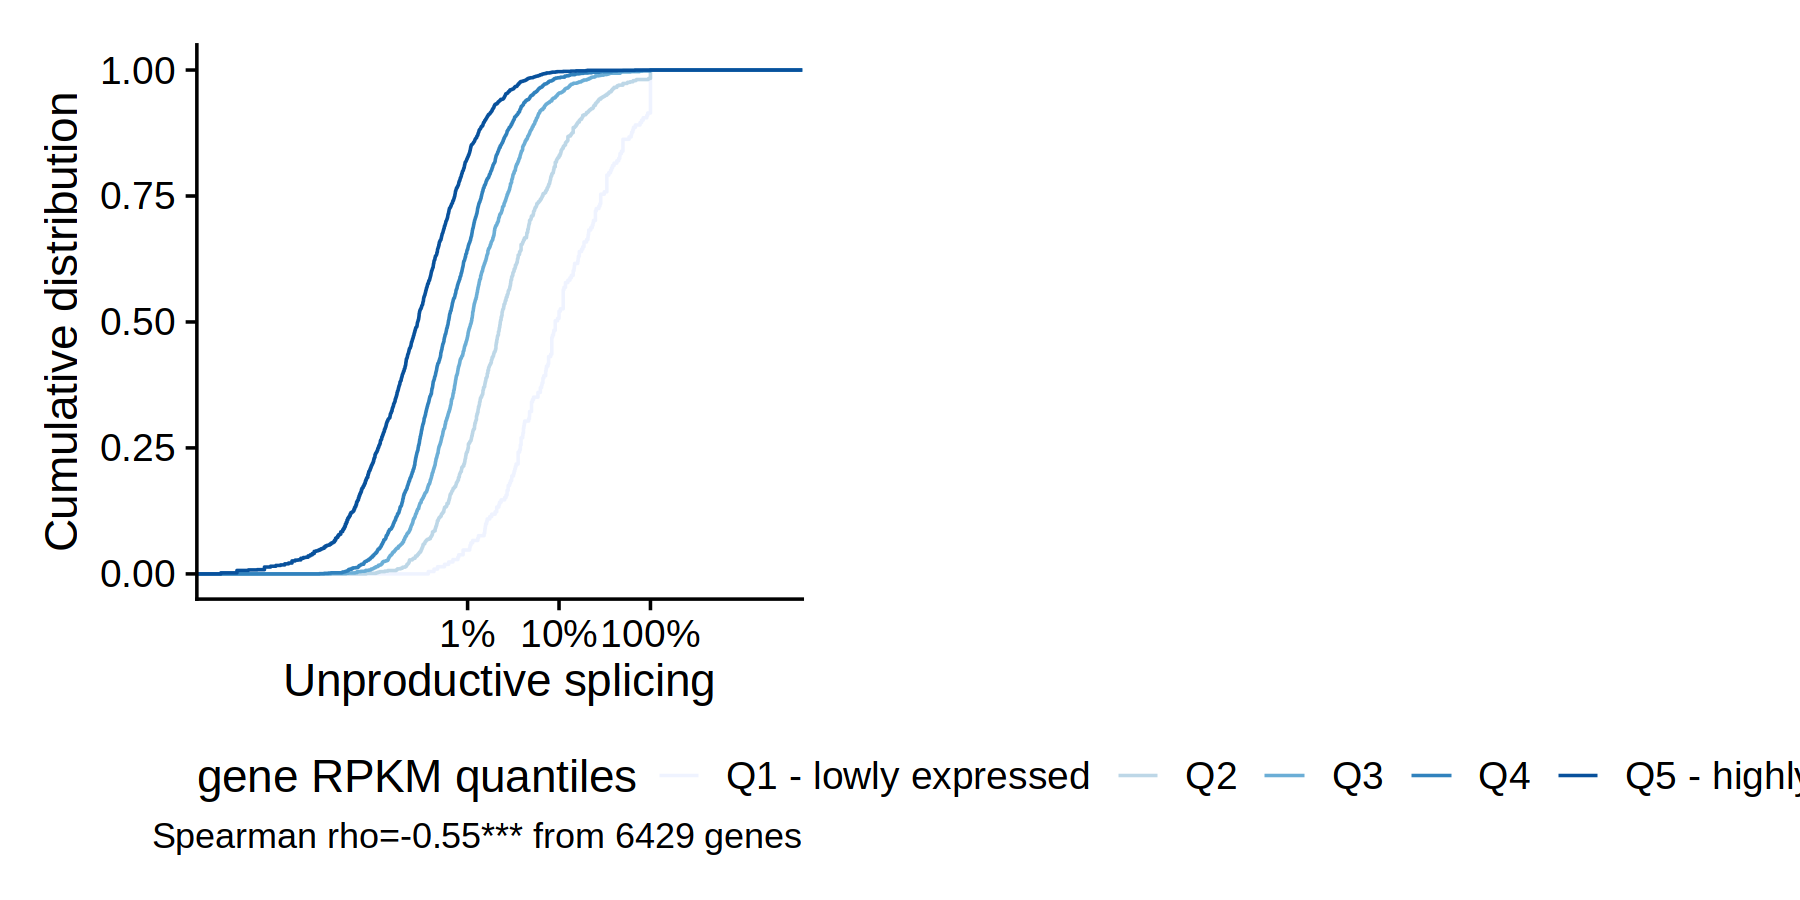

In [362]:
p3 + plot_spacer() + plot_layout(widths = c(2, 3))

In [363]:
unprod_ratio_by_gene[1:10, 1:5]
dim(unprod_ratio_by_gene)

Gene_name,HG00096,HG00097,HG00099,HG00100
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
KLHL17,0.10000,0.08696,0.07692,0.06250
PLEKHN1,0.00000,0.00000,0.00000,0.00000
ISG15,0.00000,0.00000,0.00000,0.00000
AGRN,0.00145,0.00432,0.00426,0.00797
SCNN1D,0.00000,0.00000,0.00000,0.00000
PUSL1,0.00000,0.01531,0.00000,0.00000
CPTP,0.07500,0.05263,0.12121,0.00000
TAS1R3,0.00000,0.00000,0.00000,0.00000
VWA1,0.00000,0.00000,0.00000,0.00000


[1] 12987   374

In [73]:
total_by_gene[1:5, 1:5]

Gene_name,HG00096,HG00097,HG00099,HG00100
<chr>,<int>,<int>,<int>,<int>
KLHL17,90,115,39,48
PLEKHN1,25,24,5,7
ISG15,1219,1192,1136,865
AGRN,2063,2083,940,502
SCNN1D,13,23,6,11


In [80]:
unprod_by_gene[1:5, 1:5]

Gene_name,HG00096,HG00097,HG00099,HG00100
<chr>,<int>,<int>,<int>,<int>
KLHL17,9,10,3,3
AGRN,3,9,4,4
PUSL1,0,3,0,0
CPTP,3,5,4,0
ATAD3B,3,0,1,0


In [75]:
counts_by_gene[1:5, 1:8]

chrom,clu,clu_type,intron_type,Intron_coord,Gene_name,HG00096,HG00097
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
chr1:960800:961292:clu_8_+:PR,clu_8,"PR,UP",PR,chr1:960800:961292,KLHL17,1,0
chr1:960800:961628:clu_8_+:UP,clu_8,"PR,UP",UP,chr1:960800:961628,KLHL17,0,0
chr1:961750:961825:clu_9_+:PR,clu_9,PR,PR,chr1:961750:961825,KLHL17,11,11
chr1:962047:962285:clu_10_+:UP,clu_10,"PR,UP",UP,chr1:962047:962285,KLHL17,0,1
chr1:962047:962354:clu_10_+:PR,clu_10,"PR,UP",PR,chr1:962047:962354,KLHL17,4,1
